# Udacity Deep Reinforcement Learning Nanodegree

## Project 2 (Continuous Control)

---

### 1. Environment setup

Run this notebook on root directory, following the instructions provided on README.md file.

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `env_filename` variable to point to the location of the Unity environment file.

In [2]:
env_filename = './Reacher_Linux_1_agent_NoVis/Reacher.x86'

In [3]:
env = UnityEnvironment(file_name=env_filename)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [6]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.5199999883770943


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

import random
import torch

from collections import deque
from ddpg_agent import Agent

In [8]:
# DDPG function

def ddpg(agent, n_episodes=2500, max_t=1000, print_every=1):
    """Deep Deterministic Policy Gradient (DDPG)
    
    Params
    ======
        n_episodes  (int)   : maximum number of training episodes
        max_t       (int)   : maximum number of timesteps per episode
        print_every (int)   : interval to display results

    """
    mean_scores = []                               # list of mean scores from each episode
    moving_avgs = []                               # list of moving averages
    best_score  = -np.inf
    scores_window = deque(maxlen=100)              # mean scores from most recent 100 episodes

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]       # reset environment
        states = env_info.vector_observations                   # get current state for each agent      
        scores = np.zeros(num_agents)                           # initialize score for each agent
        agent.reset()

        for t in range(max_t):
            actions = agent.act(states, add_noise=True)         # select an action
            env_info = env.step(actions)[brain_name]            # send actions to environment
            next_states = env_info.vector_observations          # get next state
            rewards = env_info.rewards                          # get reward
            dones = env_info.local_done                         # see if episode has finished
            # save experience to replay buffer, perform learning step at defined interval
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done, t)             
            states = next_states
            scores += rewards        
            if np.any(dones):                                   # exit loop when episode ends
                break

        mean_scores.append(np.mean(scores))           # save mean score for the episode
        scores_window.append(mean_scores[-1])         # save mean score to window
        moving_avgs.append(np.mean(scores_window))    # save moving average

        if i_episode % print_every == 0:
            print('\rEpisode {} > Mean: {:.1f} \t Moving Avg: {:.1f}'.format(str(i_episode).zfill(4),
                                                                             mean_scores[-1], moving_avgs[-1]))

        if moving_avgs[-1] >= 30.00 and i_episode >= 100:
            print('\nEnvironment solved in {:d} episodes! Average Score: {:.2f}'.format(i_episode-100, moving_avgs[-1]))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break

    return mean_scores, moving_avgs

In [9]:
# run the training loop
agent = Agent(state_size=state_size, action_size=action_size)
scores, avgs = ddpg(agent)

Episode 0001 > Mean: 0.5 	 Moving Avg: 0.5
Episode 0002 > Mean: 0.1 	 Moving Avg: 0.3
Episode 0003 > Mean: 0.4 	 Moving Avg: 0.4
Episode 0004 > Mean: 0.4 	 Moving Avg: 0.4
Episode 0005 > Mean: 1.6 	 Moving Avg: 0.6
Episode 0006 > Mean: 0.7 	 Moving Avg: 0.6
Episode 0007 > Mean: 0.8 	 Moving Avg: 0.7
Episode 0008 > Mean: 0.8 	 Moving Avg: 0.7
Episode 0009 > Mean: 0.2 	 Moving Avg: 0.6
Episode 0010 > Mean: 2.3 	 Moving Avg: 0.8
Episode 0011 > Mean: 1.6 	 Moving Avg: 0.9
Episode 0012 > Mean: 0.5 	 Moving Avg: 0.8
Episode 0013 > Mean: 1.3 	 Moving Avg: 0.9
Episode 0014 > Mean: 2.2 	 Moving Avg: 1.0
Episode 0015 > Mean: 1.9 	 Moving Avg: 1.0
Episode 0016 > Mean: 1.1 	 Moving Avg: 1.0
Episode 0017 > Mean: 0.8 	 Moving Avg: 1.0
Episode 0018 > Mean: 1.6 	 Moving Avg: 1.1
Episode 0019 > Mean: 0.9 	 Moving Avg: 1.0
Episode 0020 > Mean: 0.0 	 Moving Avg: 1.0
Episode 0021 > Mean: 0.6 	 Moving Avg: 1.0
Episode 0022 > Mean: 1.2 	 Moving Avg: 1.0
Episode 0023 > Mean: 0.9 	 Moving Avg: 1.0
Episode 002

Episode 0192 > Mean: 4.0 	 Moving Avg: 3.5
Episode 0193 > Mean: 4.8 	 Moving Avg: 3.5
Episode 0194 > Mean: 2.5 	 Moving Avg: 3.5
Episode 0195 > Mean: 3.0 	 Moving Avg: 3.5
Episode 0196 > Mean: 5.8 	 Moving Avg: 3.6
Episode 0197 > Mean: 5.0 	 Moving Avg: 3.6
Episode 0198 > Mean: 3.3 	 Moving Avg: 3.6
Episode 0199 > Mean: 4.2 	 Moving Avg: 3.6
Episode 0200 > Mean: 4.8 	 Moving Avg: 3.6
Episode 0201 > Mean: 5.0 	 Moving Avg: 3.6
Episode 0202 > Mean: 3.8 	 Moving Avg: 3.6
Episode 0203 > Mean: 2.9 	 Moving Avg: 3.6
Episode 0204 > Mean: 5.6 	 Moving Avg: 3.6
Episode 0205 > Mean: 5.9 	 Moving Avg: 3.7
Episode 0206 > Mean: 5.0 	 Moving Avg: 3.7
Episode 0207 > Mean: 0.5 	 Moving Avg: 3.7
Episode 0208 > Mean: 1.5 	 Moving Avg: 3.6
Episode 0209 > Mean: 2.7 	 Moving Avg: 3.6
Episode 0210 > Mean: 7.8 	 Moving Avg: 3.7
Episode 0211 > Mean: 4.2 	 Moving Avg: 3.7
Episode 0212 > Mean: 2.2 	 Moving Avg: 3.7
Episode 0213 > Mean: 3.6 	 Moving Avg: 3.7
Episode 0214 > Mean: 1.9 	 Moving Avg: 3.7
Episode 021

Episode 0383 > Mean: 7.4 	 Moving Avg: 7.4
Episode 0384 > Mean: 5.9 	 Moving Avg: 7.4
Episode 0385 > Mean: 6.8 	 Moving Avg: 7.4
Episode 0386 > Mean: 5.0 	 Moving Avg: 7.3
Episode 0387 > Mean: 7.3 	 Moving Avg: 7.3
Episode 0388 > Mean: 9.2 	 Moving Avg: 7.3
Episode 0389 > Mean: 6.3 	 Moving Avg: 7.4
Episode 0390 > Mean: 8.4 	 Moving Avg: 7.4
Episode 0391 > Mean: 6.5 	 Moving Avg: 7.4
Episode 0392 > Mean: 3.5 	 Moving Avg: 7.4
Episode 0393 > Mean: 12.1 	 Moving Avg: 7.5
Episode 0394 > Mean: 12.6 	 Moving Avg: 7.5
Episode 0395 > Mean: 11.1 	 Moving Avg: 7.5
Episode 0396 > Mean: 8.1 	 Moving Avg: 7.6
Episode 0397 > Mean: 9.8 	 Moving Avg: 7.6
Episode 0398 > Mean: 10.0 	 Moving Avg: 7.6
Episode 0399 > Mean: 9.0 	 Moving Avg: 7.6
Episode 0400 > Mean: 6.9 	 Moving Avg: 7.6
Episode 0401 > Mean: 11.1 	 Moving Avg: 7.6
Episode 0402 > Mean: 7.8 	 Moving Avg: 7.7
Episode 0403 > Mean: 10.2 	 Moving Avg: 7.7
Episode 0404 > Mean: 8.9 	 Moving Avg: 7.7
Episode 0405 > Mean: 2.4 	 Moving Avg: 7.6
Episo

Episode 0570 > Mean: 16.1 	 Moving Avg: 12.4
Episode 0571 > Mean: 12.9 	 Moving Avg: 12.5
Episode 0572 > Mean: 13.9 	 Moving Avg: 12.5
Episode 0573 > Mean: 16.9 	 Moving Avg: 12.6
Episode 0574 > Mean: 13.0 	 Moving Avg: 12.6
Episode 0575 > Mean: 12.8 	 Moving Avg: 12.6
Episode 0576 > Mean: 14.0 	 Moving Avg: 12.6
Episode 0577 > Mean: 13.3 	 Moving Avg: 12.6
Episode 0578 > Mean: 13.5 	 Moving Avg: 12.7
Episode 0579 > Mean: 13.3 	 Moving Avg: 12.7
Episode 0580 > Mean: 14.4 	 Moving Avg: 12.7
Episode 0581 > Mean: 15.8 	 Moving Avg: 12.8
Episode 0582 > Mean: 9.6 	 Moving Avg: 12.8
Episode 0583 > Mean: 16.4 	 Moving Avg: 12.8
Episode 0584 > Mean: 17.5 	 Moving Avg: 12.9
Episode 0585 > Mean: 9.3 	 Moving Avg: 12.8
Episode 0586 > Mean: 16.7 	 Moving Avg: 12.9
Episode 0587 > Mean: 14.8 	 Moving Avg: 12.9
Episode 0588 > Mean: 12.2 	 Moving Avg: 13.0
Episode 0589 > Mean: 11.3 	 Moving Avg: 13.0
Episode 0590 > Mean: 12.2 	 Moving Avg: 13.0
Episode 0591 > Mean: 26.3 	 Moving Avg: 13.1
Episode 0592

Episode 0753 > Mean: 22.5 	 Moving Avg: 17.6
Episode 0754 > Mean: 17.8 	 Moving Avg: 17.7
Episode 0755 > Mean: 16.8 	 Moving Avg: 17.6
Episode 0756 > Mean: 18.8 	 Moving Avg: 17.7
Episode 0757 > Mean: 19.2 	 Moving Avg: 17.7
Episode 0758 > Mean: 17.6 	 Moving Avg: 17.7
Episode 0759 > Mean: 15.1 	 Moving Avg: 17.7
Episode 0760 > Mean: 18.3 	 Moving Avg: 17.8
Episode 0761 > Mean: 14.7 	 Moving Avg: 17.8
Episode 0762 > Mean: 13.3 	 Moving Avg: 17.8
Episode 0763 > Mean: 15.3 	 Moving Avg: 17.8
Episode 0764 > Mean: 20.5 	 Moving Avg: 17.9
Episode 0765 > Mean: 18.2 	 Moving Avg: 17.9
Episode 0766 > Mean: 21.7 	 Moving Avg: 18.0
Episode 0767 > Mean: 20.0 	 Moving Avg: 18.0
Episode 0768 > Mean: 19.8 	 Moving Avg: 17.9
Episode 0769 > Mean: 20.7 	 Moving Avg: 18.0
Episode 0770 > Mean: 17.6 	 Moving Avg: 18.0
Episode 0771 > Mean: 18.0 	 Moving Avg: 18.0
Episode 0772 > Mean: 18.7 	 Moving Avg: 17.9
Episode 0773 > Mean: 21.7 	 Moving Avg: 18.0
Episode 0774 > Mean: 22.0 	 Moving Avg: 18.0
Episode 07

Episode 0936 > Mean: 27.2 	 Moving Avg: 24.4
Episode 0937 > Mean: 27.8 	 Moving Avg: 24.5
Episode 0938 > Mean: 27.8 	 Moving Avg: 24.6
Episode 0939 > Mean: 29.8 	 Moving Avg: 24.7
Episode 0940 > Mean: 29.6 	 Moving Avg: 24.7
Episode 0941 > Mean: 28.4 	 Moving Avg: 24.8
Episode 0942 > Mean: 26.4 	 Moving Avg: 24.9
Episode 0943 > Mean: 28.4 	 Moving Avg: 24.9
Episode 0944 > Mean: 26.6 	 Moving Avg: 24.9
Episode 0945 > Mean: 27.4 	 Moving Avg: 25.0
Episode 0946 > Mean: 29.6 	 Moving Avg: 25.1
Episode 0947 > Mean: 28.5 	 Moving Avg: 25.1
Episode 0948 > Mean: 23.5 	 Moving Avg: 25.1
Episode 0949 > Mean: 30.7 	 Moving Avg: 25.2
Episode 0950 > Mean: 19.2 	 Moving Avg: 25.1
Episode 0951 > Mean: 28.7 	 Moving Avg: 25.2
Episode 0952 > Mean: 26.7 	 Moving Avg: 25.2
Episode 0953 > Mean: 23.4 	 Moving Avg: 25.2
Episode 0954 > Mean: 29.6 	 Moving Avg: 25.3
Episode 0955 > Mean: 26.8 	 Moving Avg: 25.3
Episode 0956 > Mean: 26.5 	 Moving Avg: 25.3
Episode 0957 > Mean: 29.8 	 Moving Avg: 25.3
Episode 09

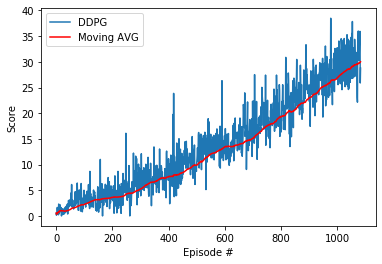

In [10]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='DDPG')
plt.plot(np.arange(len(scores)), avgs, c='r', label='Moving AVG')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left');
plt.show()

In [11]:
env.close()